In [35]:
import cv2 as cv
import numpy as np
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.filters import gaussian
from sklearn.ensemble import RandomForestRegressor

In [57]:
imgList = []
segList = []
for file in os.listdir('T0008F001F012/'):
    if file.endswith('tif'):
        imgList.append(file)
    elif file.endswith('npy'):
        segList.append(file)
imgList.sort()
segList.sort()

In [58]:
trainX_List = []
trainY_List = []

In [59]:
for i in range(len(imgList)):
    testImg = cv.imread('T0008F001F012/{}'.format(imgList[i]), -1)
    testImg_Seg = np.load('T0008F001F012/{}'.format(segList[i]))
    testImg_Seg = testImg_Seg[:, :, 0]
    testImg_Seg = -testImg_Seg + 2
    locCoord = np.where(testImg_Seg == 1)
    train_X = np.transpose(np.array(locCoord))
    train_Y = testImg[locCoord]
    trainX_List.append(train_X.copy())
    trainY_List.append(train_Y.copy())

In [60]:
trainX_Total = np.concatenate(trainX_List)
trainY_Total = np.concatenate(trainY_List)
wholeCoord = np.where(testImg > -1) # Coordinates of all pixels in image (No pixel should be lower than 0)
wholeX = np.transpose(np.array(wholeCoord))

In [61]:
testBigImg = cv.imread('testFFCImageOrigin.tif', -1).astype('float32')

In [8]:
'''
Sampling = np.random.randint(0, high = trainX_Total.shape[0] - 1, size = 100000)
trainX_Total_Sampled = trainX_Total[Sampling, :]
trainY_Total_Sampled = trainY_Total[Sampling]
'''

'\nSampling = np.random.randint(0, high = trainX_Total.shape[0] - 1, size = 100000)\ntrainX_Total_Sampled = trainX_Total[Sampling, :]\ntrainY_Total_Sampled = trainY_Total[Sampling]\n'

In [62]:
model = RandomForestRegressor(n_estimators=400, max_depth=7, random_state=0, max_samples=100000, n_jobs = 4)
model.fit(trainX_Total, trainY_Total)

RandomForestRegressor(max_depth=7, max_samples=100000, n_estimators=400,
                      n_jobs=4, random_state=0)

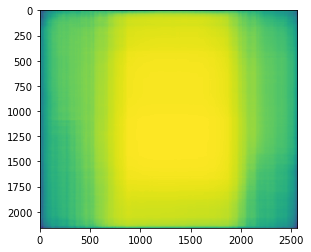

In [63]:
wholeY = model.predict(wholeX)
emptyTemp = np.zeros(testImg.shape, 'float32')
emptyTemp[wholeCoord] = wholeY
emptyTemp = gaussian(emptyTemp, sigma = 2)
plt.imshow(emptyTemp)

In [64]:
BigFlatImg = np.zeros((3 * 2160, 4 * 2560), dtype = 'float32')
for i in range(12):
    ridx = i // 4
    cidx = i % 4
    BigFlatImg[ridx * 2160 : (ridx + 1) * 2160, cidx * 2560 : (cidx + 1) * 2560] = emptyTemp / emptyTemp.mean()

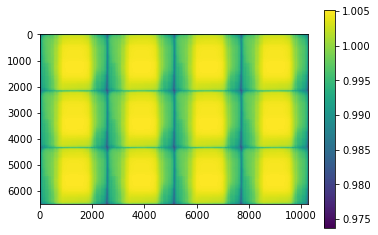

In [65]:
plt.imshow(BigFlatImg)
plt.colorbar()

In [66]:
testBigImg2 = testBigImg / resize(BigFlatImg, (3240, 5120))

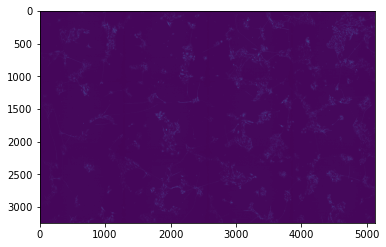

In [25]:
plt.imshow(testBigImg2)

In [67]:
cv.imwrite('testMergedImg2.tif', (testBigImg2 * (65535 / testBigImg2.max())).astype('uint16'))

True

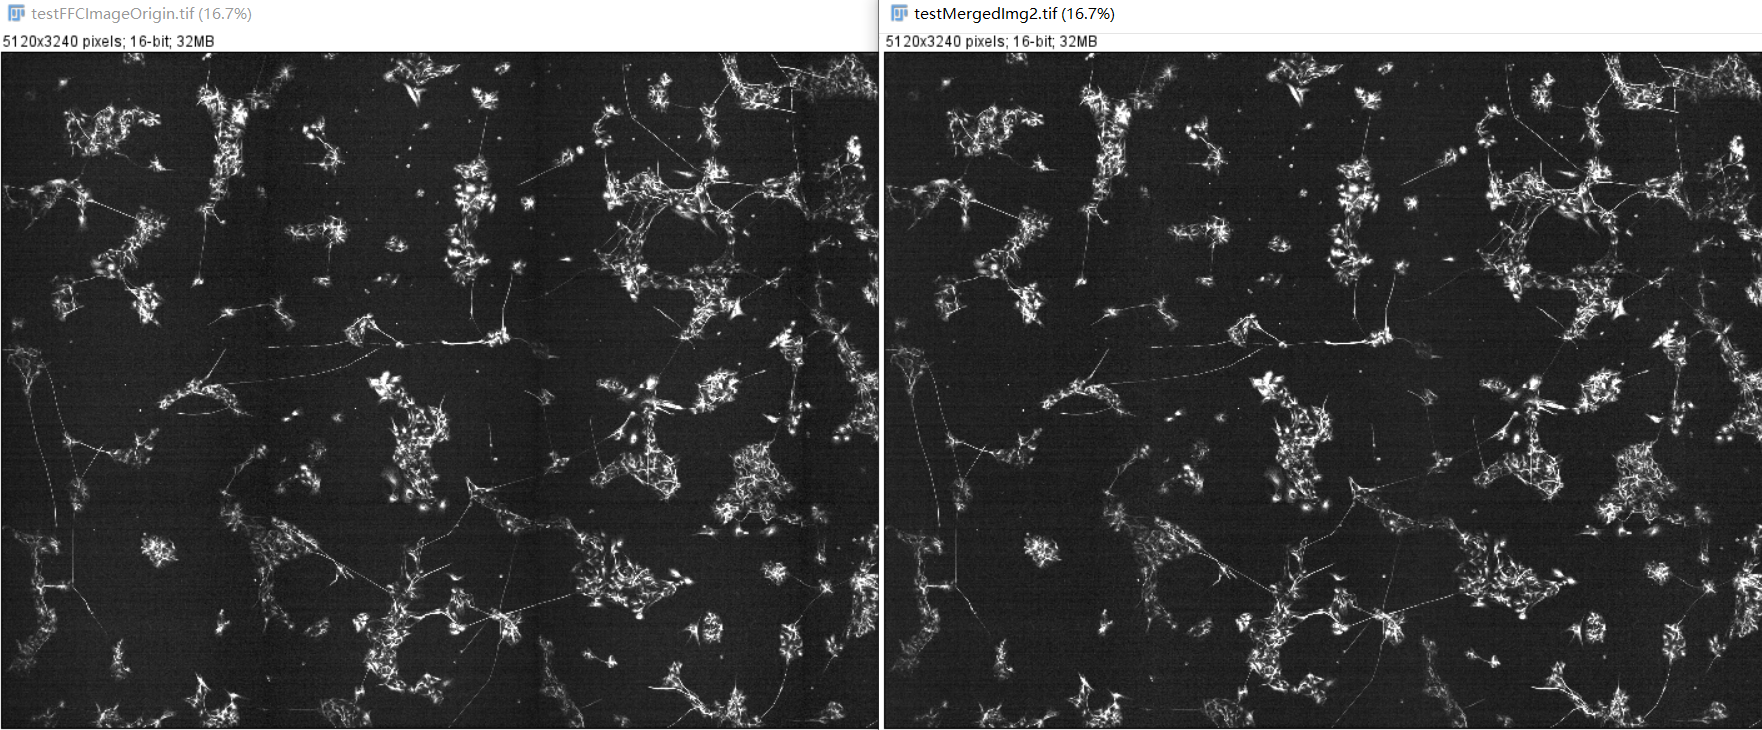

↑Before/After